Forecast Annual Visition at Utah National Parks

In [0]:
import pandas as pd
import os
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

# Ingest Data

Visition data for each park is stored in its own csv file. We collect all data into a single pandas dataframe

In [0]:
# all files in directory
all_files = os.listdir()

# just the csv's with data
csv_files = [file for file in all_files if file.endswith(".csv")]

In [0]:
# initialize the final dataset and types

# set columns and types
data = ["ts", "visitors", "park"]

# make dataframe
df_visit = pd.DataFrame(columns=data)

In [0]:
# loop through datasets

for f in csv_files:

    # extract name of park from data
    park_name = pd.read_csv(f, nrows=1).iloc[0, 0]
    # trim the ' NP' from park name
    park_name = park_name[:-3]

    # read data
    df = pd.read_csv(f, skiprows=3)
    # drop last column since it's a row-wise sum
    df.drop(df.columns[-1], axis=1, inplace=True)
    # rename id column
    df.rename(columns={"Year": "year"}, inplace=True)

    # pivot data
    df_pivot = df.melt(
        id_vars="year", var_name="month_abbr", value_name="visitors"
    ).dropna()

    # clean data
    # extract month number from month name
    def extract_month_number(month_name):
        return pd.to_datetime(month_name, format="%b").month

    df_pivot["month_num"] = df_pivot["month_abbr"].apply(extract_month_number)
    # make timestamp
    df_pivot["ts"] = pd.to_datetime(
        dict(year=df_pivot.year, month=df_pivot.month_num, day=1)
    )
    # convert visitors to numeric
    df_pivot["visitors"] = pd.to_numeric(df_pivot["visitors"].str.replace(",", ""))
    # add park identifier
    df_pivot["park"] = park_name
    # select needed columns
    df_final = df_pivot[["ts", "visitors", "park"]]

    df_visit = pd.concat([df_visit, df_final], ignore_index=True)

In [0]:
# clean data types
df_visit = df_visit.convert_dtypes()

# Exploratory Data Analysis

In [0]:
# set colors
# use brand colors of Mighty 5 campaign (https://www.visitutah.com/places-to-go/parks-outdoors/the-mighty-5)
orange = "#ed6417"
d_blue = "#012d50"
red = "#772116"
l_blue = "#51b8f3"
gray = "#516c85"

colors = [orange, d_blue, red, l_blue, gray]

## Overall Visitation

We have data starting in 1979 for each park. Each has a monthly observation through March 2024

In [0]:
(
    df_visit.groupby("park")
    .agg(
        tot_visitors=("visitors", "sum"),
        ts_min=("ts", "min"),
        ts_max=("ts", "max"),
        tot_months=("ts", "count"),
    )
    .sort_values("tot_visitors", ascending=False)
)

,tot_visitors,ts_min,ts_max,tot_months
park,,,,
Zion,119799075,1979-01-01,2024-03-01,543
Bryce Canyon,54430540,1979-01-01,2024-03-01,543
Arches,39894589,1979-01-01,2024-03-01,543
Capitol Reef,30093495,1979-01-01,2024-03-01,543
Canyonlands,18593469,1979-01-01,2024-03-01,543


Visitation grew in the late 80's and stabilized for about 20 years. It then spiked in the 2010's with the Mighty 5 campaign.

There was a dip in 2020 due to covid retrictions

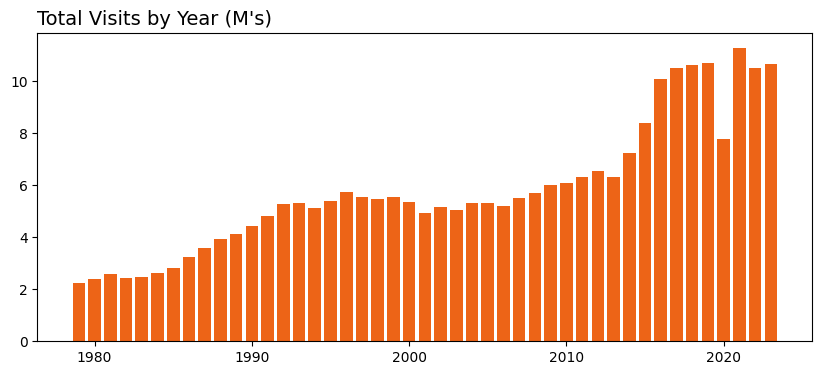

In [0]:
visits_by_year = (
    df_visit.loc[
        (df_visit["ts"].dt.year < 2024)
    ]  # filter current year since it's incomplete
    .groupby(df_visit["ts"].dt.year)
    .agg(tot_visitors=("visitors", "sum"))
    .reset_index()
    .rename(columns={"ts": "year"})
)

visits_by_year["ms_visitors"] = visits_by_year["tot_visitors"] / 1000000  # get M's

# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(visits_by_year["year"], visits_by_year["ms_visitors"], color=[orange])

ax.set_title("Total Visits by Year (M's)", fontsize=14, loc="left")

# Display the plot
plt.show()

## Visitation by Park

All parks experienced a similar growth **trend** in visitation.   

The ranking of the parks has remained stable for nearly the whole dataset. Zion is the most visited and Canyonlands the least

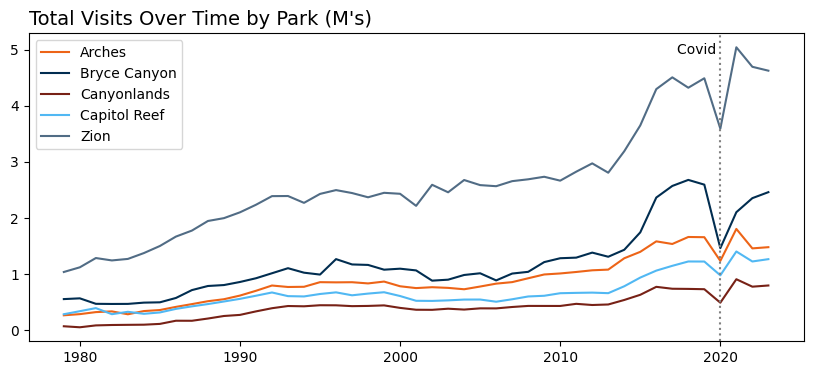

In [0]:
visits_by_year_by_park = (
    df_visit.loc[
        (df_visit["ts"].dt.year < 2024)
    ]  # filter current year since it's incomplete
    .groupby([df_visit["ts"].dt.year, "park"])
    .agg(tot_visitors=("visitors", "sum"))
    .reset_index()
    .rename(columns={"ts": "year"})
)

visits_by_year_by_park["ms_visitors"] = (
    visits_by_year_by_park["tot_visitors"] / 1000000
)  # get M's

# Create the line plot
fig, ax = plt.subplots(figsize=(10, 4))

i = 0

for park, data in visits_by_year_by_park.groupby("park"):
    ax.plot(data["year"], data["ms_visitors"], label=park, color=colors[i])
    i += 1

ax.set_title("Total Visits Over Time by Park (M's)", fontsize=14, loc="left")

ax.axvline(2020, color="gray", linestyle=":")
ax.text(2020, 5, "Covid ", horizontalalignment="right", verticalalignment="center")

ax.legend()

# Display the plot
plt.show()

There is clear **seasonality** in visitation.

Visits increase during the summer months

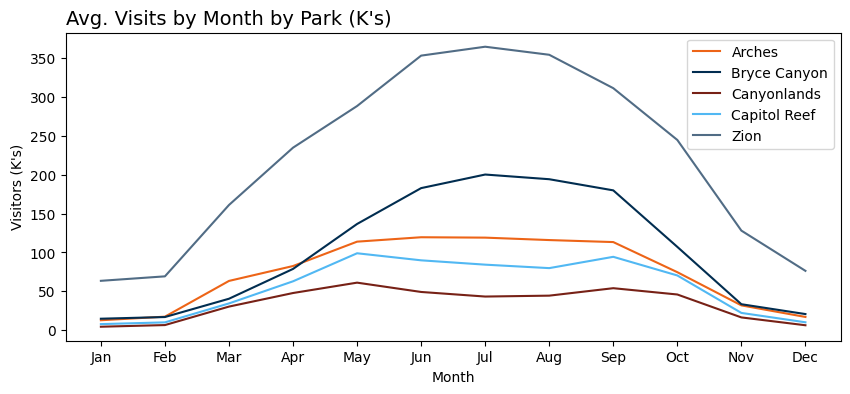

In [0]:
visits_by_month_by_park = (
    df_visit.loc[df_visit["ts"].dt.year < 2024] # filter current year since it's incomplete
    .assign(month=df_visit["ts"].dt.month)
    .assign(month_name=df_visit['ts'].dt.strftime('%b'))
    .groupby(['month', 'month_name', 'park'])
    .agg(avg_visitors=("visitors", "mean"))
    .reset_index()
)

visits_by_month_by_park["ks_visitors"] = (
    visits_by_month_by_park["avg_visitors"] / 1000
)  # get K's

#sort by order of months
visits_by_month_by_park = visits_by_month_by_park.sort_values("month")

# Create the line plot
fig, ax = plt.subplots(figsize=(10, 4))

i = 0

#plot each series
for park, data in visits_by_month_by_park.groupby("park"):
    ax.plot(data["month_name"], data["ks_visitors"], label=park, color=colors[i])
    i += 1

#set labels
ax.set_title("Avg. Visits by Month by Park (K's)", fontsize=14, loc="left")
ax.set_xlabel("Month")
ax.set_ylabel("Visitors (K's)")

ax.legend()

# Display the plot
plt.show()

Here is the overall visition by park.

Notice the increasing trend and strong seasonality

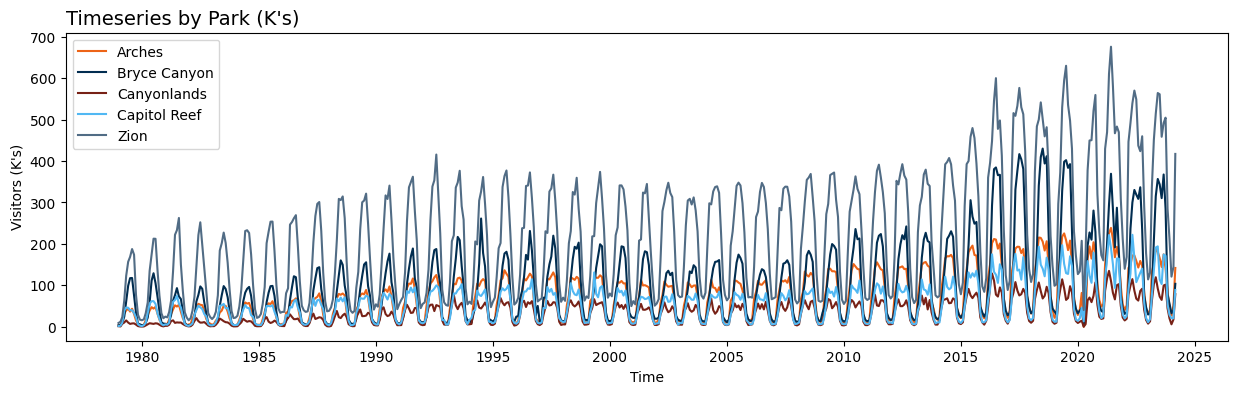

In [0]:
df_total = df_visit.copy()

df_total["ks_visitors"] = (
    df_total["visitors"] / 1000
)  # get K's

#sort on ts
df_total = df_total.sort_values("ts")

# Create the line plot
fig, ax = plt.subplots(figsize=(15, 4))

i = 0

#plot each series
for park, data in df_total.groupby("park"):
    ax.plot(data["ts"], data["ks_visitors"], label=park, color=colors[i])
    i += 1

#set labels
ax.set_title("Timeseries by Park (K's)", fontsize=14, loc="left")
ax.set_xlabel("Time")
ax.set_ylabel("Visitors (K's)")

ax.legend()

# Display the plot
plt.show()

Let's zoom in on that covid year.

The total visition was down and the peak visitation shifted to later in the year. We'll have to account for that in the model

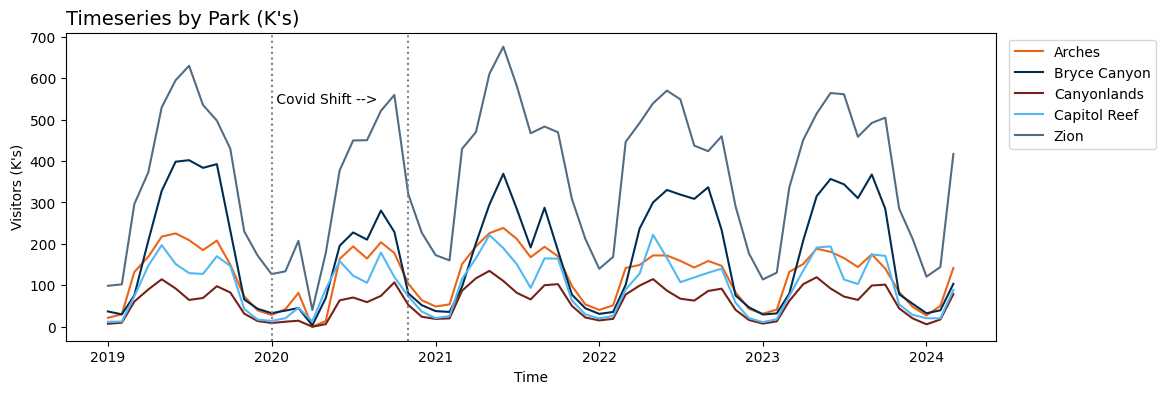

In [0]:
df_covid = df_visit.copy()

df_covid["ks_visitors"] = (
    df_covid["visitors"] / 1000
)  # get K's

df_covid = (
  df_covid.loc[df_covid["ts"].dt.year > 2018] # filter to covid range
)

#sort on ts
df_covid = df_covid.sort_values("ts")

# Create the line plot
fig, ax = plt.subplots(figsize=(12, 4))

i = 0

#plot each series
for park, data in df_covid.groupby("park"):
    ax.plot(data["ts"], data["ks_visitors"], label=park, color=colors[i])
    i += 1

#set labels
ax.set_title("Timeseries by Park (K's)", fontsize=14, loc="left")
ax.set_xlabel("Time")
ax.set_ylabel("Visitors (K's)")

ax.legend(loc='upper right', bbox_to_anchor=(1.18, 1)) # Set the legend position outside the plot area

covid_start = '2020-01-01'
covid_end = '2020-11-01'
ax.axvline(np.datetime64(covid_start), color="gray", linestyle=":")
ax.axvline(np.datetime64(covid_end), color="gray", linestyle=":")
ax.text(np.datetime64(covid_start), 540, " Covid Shift -->", horizontalalignment="left")

# Display the plot
plt.show()

# Modeling

For this project, I will be using the Prophet algorithm developed by meta. Read the docs [here](https://facebook.github.io/prophet/).

The algorithm takes a bayesian approach to estimating the trend and seasonality of the time series to inference future values. 

import packages for time series modeling

In [0]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


Let's set up a dataframe with the time series for just one park for a simple example 

In [0]:
park = 'Arches'

df_arches = (
    df_visit.loc[(df_visit["park"] == park)]
    .rename(columns={"visitors": "y",
                     "ts": "ds"}) #rename for prophet
    .sort_values('ds')
)

df_arches

,ds,y,park
2217,1979-01-01,2970,Arches
2263,1979-02-01,3135,Arches
2309,1979-03-01,14659,Arches
2354,1979-04-01,31818,Arches
2399,1979-05-01,39266,Arches
...,...,...,...
2625,2023-11-01,83843,Arches
2670,2023-12-01,48037,Arches
2172,2024-01-01,27174,Arches
2218,2024-02-01,50517,Arches


## Base Model

###Fit and Forecast
Let's do a base model with the standard parameters

In [0]:

model = Prophet() #instantiate a model
model.fit(df_arches) #fit onto the historical data

periods = 33 #forecast 33 months into the future (through 2026)
future = model.make_future_dataframe(periods=periods, freq = 'MS') #make a monthly future dataset
forecast = model.predict(future) #predict over future dates

22:44:28 - cmdstanpy - INFO - Chain [1] start processing
22:44:28 - cmdstanpy - INFO - Chain [1] done processing


###Explore Components
Let's explore the forecast

Let's break down the chart below:
- time is on the x-axis and visitors is on the y-axis
- the solid blue line is the forecasted yhat value
- the light blue line is the uncertainty
- the black dots are the actual observed values


The model seems to do a poor job at the beginning and end of the series. This suggests a multiplicative growth instead of an additive growth could do better

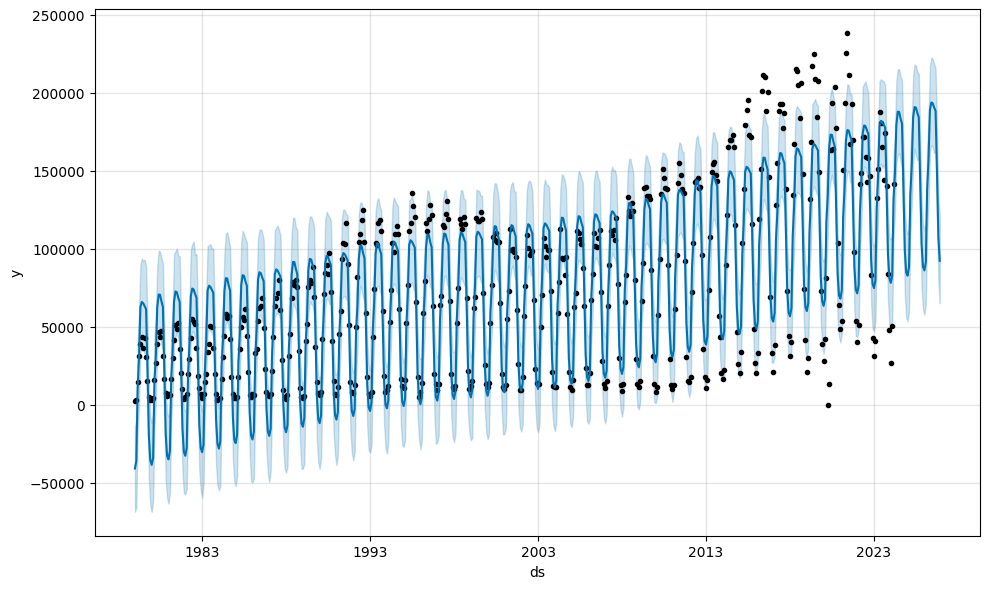

In [0]:
plt = model.plot(forecast)

Here we can see the model picked up the linerar trend of growing visitors. It also found the seasonlity we discovered during our eploratry analysis

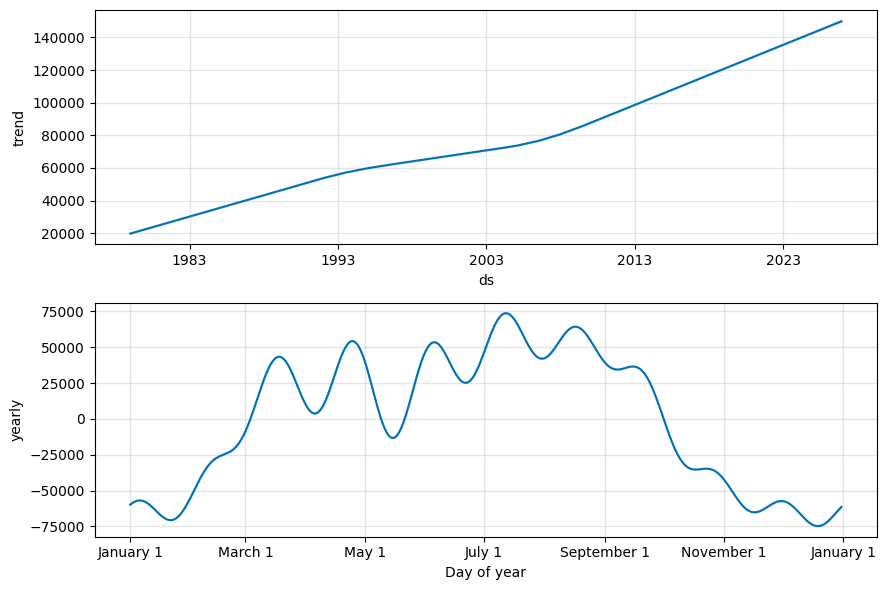

In [0]:
plt = model.plot_components(forecast)

This graph shows how the model estimated the trend. The growth trend stayed consistent for about 20 years. The model then picked up the softening growth around 2000. It then picked up the stronger growth around 2010. That trend has continued through today and into the future predicitons.

In [0]:
24-9

15

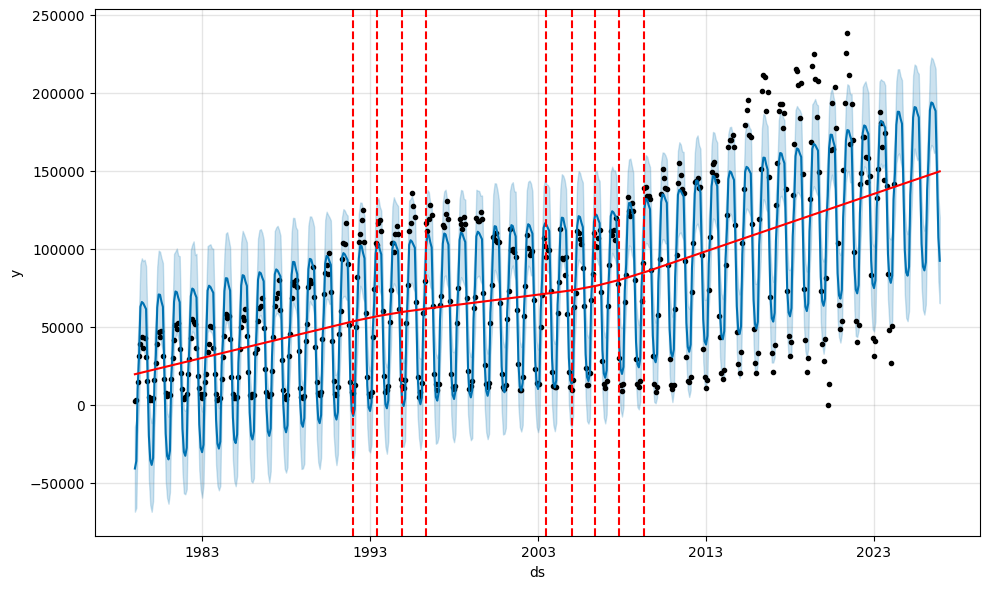

In [0]:
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)


###Evaluation
We can evaluate the model using cross-validation. We can build a model based on historical data at 'cutoffs.' At each cutoff, we build a model based on data before the cutoff, forecast two years into the future, and compare the forecast with actuals. This gives us a sense of how accurate we can expect the model to be going forward.

In [0]:
initial_years = 20 #start setting cutoffs 20 years into the dataset
period_years = 2 #set a cutoff every two years
horizon_years = 2 #for each cutoff, forecast 2 years into the future

df_cv = cross_validation(model,
                         initial=f'{initial_years*365} days',
                         period=f'{period_years*365+30} days', #shift by a month so the cutoffs are not all at same time of year
                         horizon =f'{horizon_years*365} days',
                         disable_tqdm=True #disable print outs
                         )


22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:30 - cmdstanpy - INFO - Chain [1] done processing
22:44:30 - cmdstanpy - INFO - Chain [1] start processing
22:44:31 - cmdstanpy - INFO - Chain [1] done processing
22:44:31 - cmdstanpy - INFO - Chain [1] start processing
22:44:31 - cmdstanpy - INFO - Chain [1]

The resulting dataframe is a table of point estimates for a certain time made at a certain cutoff

In [0]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1999-05-01,106382.639585,88278.309114,122720.671012,120213,1999-04-12
1,1999-06-01,111358.409140,94164.350744,128627.338563,118326,1999-04-12
2,1999-07-01,114557.529564,98169.619658,130784.592373,118042,1999-04-12
3,1999-08-01,119719.876379,102227.570857,135593.145619,124130,1999-04-12
4,1999-09-01,105232.249938,87256.238102,121989.772400,119657,1999-04-12
...,...,...,...,...,...,...
282,2023-11-01,106802.529845,79753.101232,131549.428093,83843,2022-03-02
283,2023-12-01,93327.721612,64250.659599,119550.471469,48037,2022-03-02
284,2024-01-01,91457.074688,64607.144920,120113.478050,27174,2022-03-02
285,2024-02-01,95433.540614,70442.320282,122553.501030,50517,2022-03-02


With the performance metrics function, we can calcualte several error metrics. A few key ideas:
- metrics are always averaged over all cutoffs (you can think of these as folds in k-fold CV)
- metrics are averaged within a cutoff based on the rolling window parameter
  - at a given cutoff, we make predictions 1,2,3...24 months into the future.
  - When rolling window is 1, we average all of these together and get one single estimate for error.
  - When rolling window is 0, we don't average these at all and we get an estimate for error at each 'lag' of prediction (1 month, 2 month, etc). 
  - When rolling window is X%, we average all of the lags in the X% of the horizon to get as estimate for error.

Here, we use the suggested rolling window of 0.1. That means we will get error estimates for 90% of our window.
- Our first estimate will be 10% through our window and average all points within lag of 0% to 10%
- We then have an estimate 11% of the way through our window that averages all the points at lags 1% to 11% of the way through the window.
- This keeps going until the last estimate takes the average of all errors 90% to 100% of the way through the window.

For more info, see [this](https://github.com/facebook/prophet/issues/1773) discussion on github. 

In [0]:
window = 0.1#set window
df_p = performance_metrics(df_cv, rolling_window=window)
df_p

,horizon,mse,rmse,mae,mdape,smape,coverage
0,84 days,1.177105e+09,34308.969878,20356.587857,0.135804,0.330498,0.571429
1,85 days,1.170301e+09,34209.662281,19893.680662,0.135804,0.327170,0.571429
2,86 days,1.174028e+09,34264.096228,20054.096908,0.161953,0.347918,0.571429
3,87 days,1.188413e+09,34473.368304,20510.448117,0.192616,0.375021,0.535714
4,88 days,1.205037e+09,34713.649298,21251.495591,0.193188,0.381850,0.500000
...,...,...,...,...,...,...,...
186,726 days,8.988660e+08,29981.094554,25764.825040,0.214356,0.299765,0.345238
187,727 days,8.856606e+08,29760.050757,25399.215000,0.214356,0.288674,0.357143
188,728 days,8.496306e+08,29148.423694,24761.356491,0.214356,0.290804,0.392857
189,729 days,9.053958e+08,30089.794918,25372.866419,0.214356,0.315042,0.392857


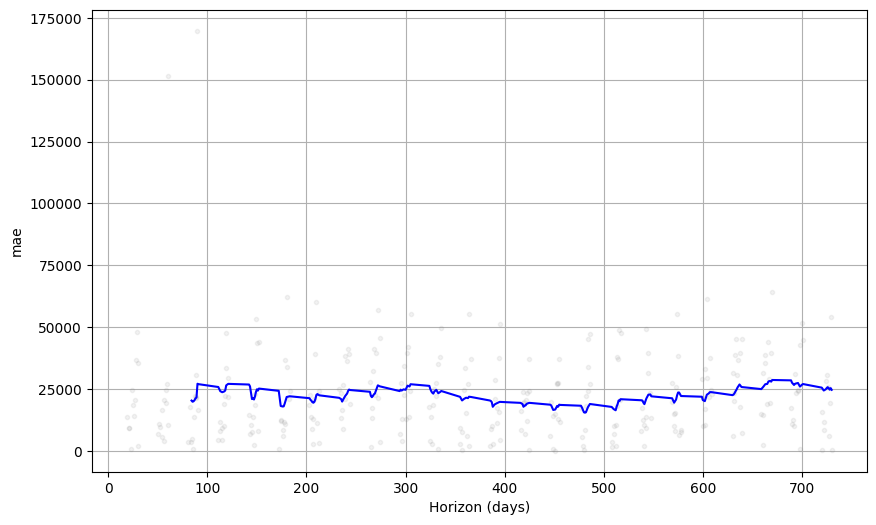

In [0]:
fig = plot_cross_validation_metric(df_cv, metric='mae', rolling_window=window)

The mae error metric stays remarkably consistent throughout the window. This means that forecasts for the near future tend to be just as accuarate as forecasts for the far future.

To more easily compare between models, it makes sense to aggregate the metrics over the entire window and get a total error score for the model.

Let's create a dataframe to hold model performance scores so we can compare over time.

In [0]:
#get base model performance

window = 1#set window to average over whole window
base_model_performance = performance_metrics(df_cv, rolling_window=window)
base_model_performance['model'] = 'base'

In [0]:
#initialize compare dataframe
df_compare = pd.DataFrame(columns=df_p.columns.tolist())

#add row for base model
df_compare = pd.concat([df_compare, base_model_performance])

In [0]:
df_compare

,horizon,mse,rmse,mae,mdape,smape,coverage,model
0,730 days,8.320482e+08,28845.246212,22004.212597,0.199323,0.322686,0.473868,base


The smape is about 32%. This means our forecasts are, on average, 32% off from the true visitation. Let's see if we can adjust the model to perform better.

(sMAPE is a bit more complicated, but in our use case we can interpret it like this. For more discussion see this [post](https://medium.com/@davide.sarra/how-to-interpret-smape-just-like-mape-bf799ba03bdc)).

## Model Version 1

Prophet allows us to set several hyperparamters to adjust the model. Let's see if changing these can improve our model!

###Fit and Forecast
For version 1, let's change a couple parameters to see if we can get a better fit.


In [0]:
model_1 = Prophet(
    changepoint_range=0.87,#by default, prophet only looks at first 80% of series for trend changes. For our dataset that means the trend cannot change after 2015. We do see a spike in visiation starting around 2013-2015, so we are going to extend the range to 87% (through 2017)
    seasonality_mode='multiplicative' #this allows the magnitude of the seasonality effect to change with the trend. By default, the 'additive' model only adds the effect, meaning it is constant through the whole time series
) #instantiate a model

model_1.fit(df_arches) #fit onto the historical data

periods = 33 #forecast 33 months into the future (through 2026)
future = model_1.make_future_dataframe(periods=periods, freq = 'MS') #make a monthly future dataset
forecast = model_1.predict(future) #predict over future dates


22:44:32 - cmdstanpy - INFO - Chain [1] start processing
22:44:32 - cmdstanpy - INFO - Chain [1] done processing


###Explore Components
Let's see if the forecast improved

Notice that the seasonality now adjusts with the trend. In the base model, the seasonality was too strong at the beginning of the timeseries and not strong enough at the end. It now matches the magnitude

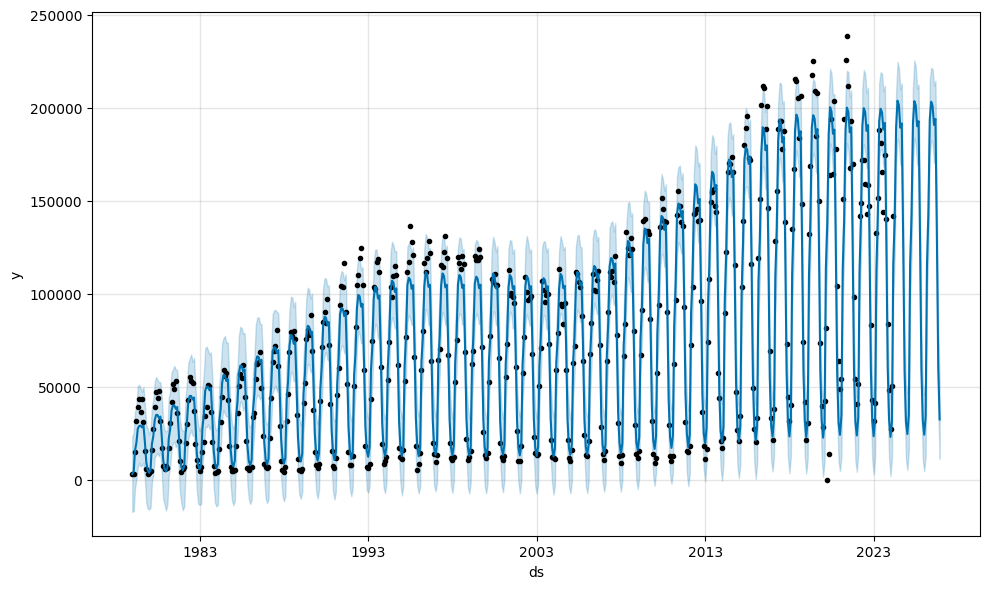

In [0]:
plt = model_1.plot(forecast)

Notice that since we extended the changepoint range, the forecast tempers the large growth in the early 2010's with the leveling out visitation in the late 2010's

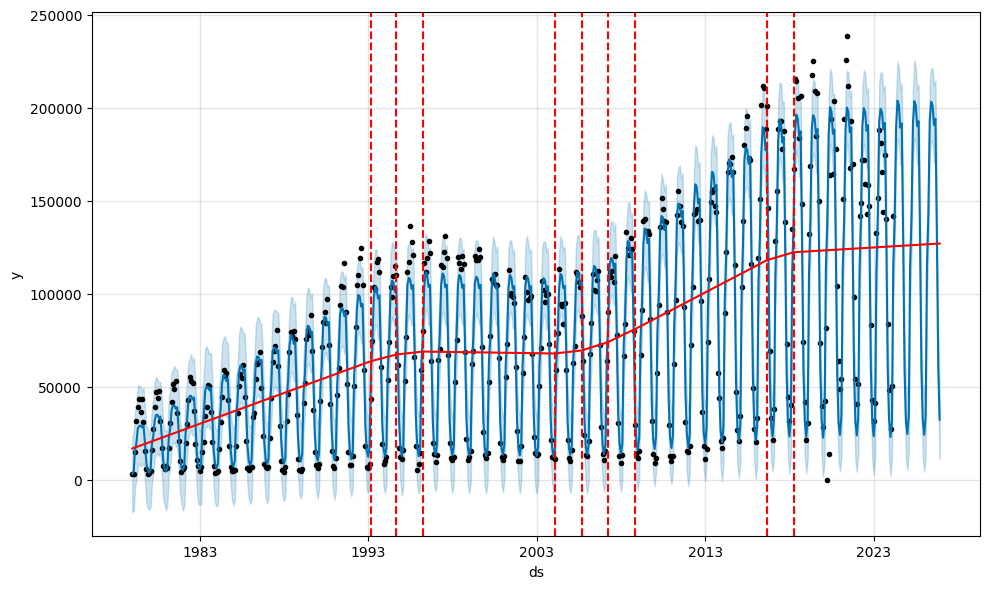

In [0]:
fig = model_1.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model_1, forecast)

###Evaluation


In [0]:
#perform cross_validation
df_cv = cross_validation(model_1,
                         initial=f'{initial_years*365} days',
                         period=f'{period_years*365+30} days', #shift by a month so the cutoffs are not all at same time of year
                         horizon =f'{horizon_years*365} days',
                         disable_tqdm=True #disable print outs
                         )


22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing
22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing
22:44:33 - cmdstanpy - INFO - Chain [1] start processing
22:44:33 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1] done processing
22:44:34 - cmdstanpy - INFO - Chain [1] start processing
22:44:34 - cmdstanpy - INFO - Chain [1]

In [0]:
#get model v1 performance

window = 1#set window to average over whole window
v1_performance = performance_metrics(df_cv, rolling_window=window)
v1_performance['model'] = 'version_1'

#add row for base model
df_compare = pd.concat([df_compare, v1_performance])

In [0]:
df_compare

,horizon,mse,rmse,mae,mdape,smape,coverage,model
0,730 days,8.320482e+08,28845.246212,22004.212597,0.199323,0.322686,0.473868,base
0,730 days,6.610592e+08,25711.071027,15020.767514,0.138208,0.188965,0.421603,version_1


All metrics except for coverage have improved! Notably, the smape is now down to 19%.